# Python for kdb+
---------------
![PyQ logo](files/logo/logo-slides.svg)
## Alexander Belopolsky
### Enlightenment Research LLC
### March 15, 2017

# A bit of history

- 2003: PyK, a Python wrapper for libk20
- 2006: first public release (serpent.speak)
- 2007: p)
- 2012: kdb+ 3.x, Python 3.x
- 2015: PyPI, pyq.enlnt.com
- 2017: PyQ 4.0

# Image processing

In Python reading image files is easy:

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
%q \c 5 60
from pyq import q, K
import os, sys

In [2]:
from matplotlib import pyplot as plt
img = plt.imread('images/Lenna.jpg')

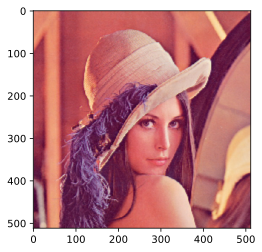

In [3]:
plt.imshow(img);

In [4]:
img.dtype, img.shape

(dtype('uint8'), (512, 512, 3))

## What can we do in q?

We can read the raw data ...

In [5]:
%q read1`:images/Lenna.jpg

0xffd8ffe000104a46494600010101004900490000fffe002d48616e6..

but since it is compressed, it is not very useful.

## Extend q with Python

In [6]:
def read_image(path):
    path = str(path).lstrip(':')
    x = plt.imread(path)
    return K(x)
ir = q('{x enlist y}', read_image)
q.set('.im.read', ir)

`.im.read

In [7]:
%q .im.read`:images/Lenna.jpg

0xe18a80 0xe0897f 0xdf887e 0xdf877b 0xe3897e 0xdd8378 0xe5..
0xde8a7f 0xe0897f 0xe0897f 0xe0887c 0xe28a7e 0xdc8277 0xe5..
0xde8a7f 0xe0897f 0xe18a80 0xe0887c 0xe28a7e 0xdd8378 0xe3..
0xe08a7d 0xe18b7e 0xe18b7e 0xe0887c 0xe1897d 0xdd8378 0xe3..
0xe28c7f 0xe38b7f 0xe1897b 0xde8678 0xe1887a 0xdd8476 0xe4..
0xe38a7a 0xe38a7a 0xe18878 0xdd8474 0xe18878 0xdf8374 0xe5..
0xe38876 0xe38876 0xe18674 0xdf8472 0xe38876 0xe08572 0xe3..
0xe18674 0xe18674 0xe08572 0xde8370 0xe58876 0xe18472 0xe3..
0xde826b 0xdf836c 0xe0846d 0xe0846f 0xe18570 0xe28573 0xe2..
..

## Is it fast?

In [8]:
%q \t img:.im.read`:images/Lenna.jpg

34

In [9]:
%time img = plt.imread('images/Lenna.png');

CPU times: user 23.2 ms, sys: 3.42 ms, total: 26.7 ms
Wall time: 29.4 ms


In [10]:
q.flat = img.flatten()
q.shape = img.shape
%q \t shape # flat

36

## Make it a library

In [11]:
%%q -l im.p
img:.im.read`:images/Lenna.png
`:images/Lenna.bmp imsave img

In [12]:
%cat im.p

from pyq import q, K
from matplotlib import pyplot as plt

def read_image(path):
    path = str(path).lstrip(':')
    x = plt.imread(path)
    return K(x)
r = q('{x enlist y}', read_image)
q.set('.im.read', r)

def save_image(path, image):
    path = str(path).lstrip(':')
    plt.imsave(path, image)
q.set('.im.save', save_image)
q).q.imsave:{.im.save(x;y)}


## What if the data is already in q?

In [13]:
img2 = %q flip reverse img

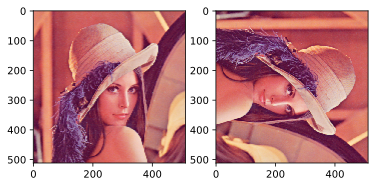

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(q.img)
ax2.imshow(img2);

# About this notebook

Python and q in one process

In [15]:
os.getpid(), q('.z.i,.z.f')

(41296, 41296i
`pyq-kernel.p)

A kdb+ port is open

In [16]:
%q \p

1024i

In [17]:
os.system('(echo answer:42 | qcon :%d)&' % _);

In [18]:
%q answer

42

# What's New in PyQ 4.0

  * Enhanced `q)` prompt with syntax highlighting.
  * New operators: `<<`, `>>` and `@`.
  * Improved means for constructing `K` objects of arbitrary types.
  * Type casts using attribute syntax.
  * Improved numpy interoperability.
  * Restored support for KDB+ 2.x.
  * Better documentation.
  * More `k.h` functions are exposed to Python internally.
  * Added convenience scripts for starting different interactive sessions.
  * Additional conversions between `K` and native Python objects.
  * Redesigned adverbs

## Enhanced `q)` prompt

Install `prompt_toolkit` and your q session in pyq will look like this:

![q session](files/images/q-prompt.png)

## New operators

### Shift operators

In [19]:
q.til(10) << 3

3 4 5 6 7 8 9 0N 0N 0N

In [20]:
q.til(10) >> 3

0N 0N 0N 0 1 2 3 4 5 6

### Apply / compose operator

(Available since Python 3.5.)

In [21]:
q.til @ 5

0 1 2 3 4

In [22]:
dot = q.sum @ q('*')
dot([1, 2, 3], [3, 2, 1])

10

## Typed constructors and  casts

In [23]:
colors = K(['white', 'blue', 'red'])

In [24]:
colors

`white`blue`red

In [25]:
K.string(["Kenneth E. Iverson", "Arthur Whitney", ])

"Kenneth E. Iverson"
"Arthur Whitney"

In [26]:
colors.string

"white"
"blue"
"red"

## Special values

In [27]:
>>> for x in [K.int, K.float, K.date, K.timespan]:
        print(x.na, x.inf)

0Ni 0Wi
0n 0w
0Nd 0Wd
0Nn 0Wn


## Better interoperability with NumPy

### Matrices and arrays of higher dimensions

In [28]:
import numpy
q.x = numpy.arange(12, dtype=numpy.uint8).reshape((2, 3, 2))
q.x

0x0001 0x0203 0x0405
0x0607 0x0809 0x0a0b

back to numpy

In [29]:
numpy.array(q.x)

array([[[ 0,  1],
        [ 2,  3],
        [ 4,  5]],

       [[ 6,  7],
        [ 8,  9],
        [10, 11]]], dtype=uint8)

### Times, dates and timedeltas

In [30]:
months = q('2000.01m + til 3')
numpy.array(months)

array(['2000-01', '2000-02', '2000-03'], dtype='datetime64[M]')

In [31]:
a = numpy.asarray(months.data)
a

array([0, 1, 2])

In [32]:
a += 17 * 12
months

2017.01 2017.02 2017.03m

## More Python to q conversions

### Complex numbers

In [33]:
q.z = [1 + 2j, 3 + 4j, 5 + 6j]
q.z

re im
-----
1  2 
3  4 
5  6

In [34]:
[complex(x) for x in q.z]

[(1+2j), (3+4j), (5+6j)]

In [35]:
import cmath
cmath.exp(q.z.first)

(-1.1312043837568135+2.4717266720048188j)

### Path objects 

In [ ]:
import pathlib
path = pathlib.Path('xyz')
q.set(path, 42)

In [ ]:
q.get(path)

### Named tuples 

In [ ]:
from collections import namedtuple
Point = namedtuple('Point', 'x,y')

In [ ]:
q.point = Point(1, 2)
%q point

In [ ]:
q.points = [Point(1, 2), Point(3, 4), Point(5, 6)]
%q points

## Redesigned adverbs

In [ ]:
K.over, q.over

In [ ]:
f = q('{(0,x)+x,0}')
f.scan(6, 1)

In [ ]:
f.over(6, 1)

# Installation
## Python for kdb+

(free for use with kdb+ personal edition)

```
pip install -i https://pyq.enlnt.com --no-binary pyq pyq
```

## PyQ kernel for Jupyter 

(free)

```
pip install pyq-kernel
pyq -m pyq.kernel install
```

----------
For a 64-bit license and support, please contact “PyQ License” &lt;<pyq-lic@enlnt.com>&gt;.<br/>
These slides are available at &lt;<http://pyq.enlnt.com/pyq-2017>&gt;.